In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [46]:
variables_path = Path("./data/variables/")
figures_path = Path("./viz/embeddings")
embeddings_data_path = Path("data/embeddings/")

In [47]:
# plt.style.use("matplotlib_style.txt")

Pipeline from PubMedBERT embeddings to two dimensional embedding

# Import data

In [48]:
%%time
%%memit
embeddings_reparsed_all = np.load(
    embeddings_data_path
    / "embeddings_microsoft_BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext_18609.npy"
)

peak memory: 426.92 MiB, increment: 103.50 MiB
CPU times: user 63.8 ms, sys: 70.3 ms, total: 134 ms
Wall time: 581 ms


In [49]:
embeddings_reparsed_all.shape

(18609, 768)

In [50]:
%%capture cap

UsageError: %%capture is a cell magic, but the cell body is empty.


%%capture cap

# t-SNE

Annealing exgg=1, n_iter=2000 

## Affinities
- see https://opentsne.readthedocs.io/en/latest/api/affinity.html#openTSNE.affinity.Uniform
- Returns an NxM affinity matrix expressing interactions between N new data points the initial NxM data samples.
- Uniform: Compute affinities using nearest neighbors and uniform kernel in the ambient space.


In [51]:
A = affinity.Uniform(
    embeddings_reparsed_all,
    k_neighbors=10,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

In [52]:
with open(variables_path / "verbose_tsne_affinities_reparsed.txt", "w") as f:
    f.write(cap.stdout)

In [53]:
# save results
sp.sparse.save_npz(variables_path / "affinities_P_bert_reparsed", A.P)

In [54]:
# load affinities P
affinities_P_bert_reparsed = sp.sparse.load_npz(
    variables_path / "affinities_P_bert_reparsed.npz"
)

In [55]:
# create the affinities object

A = Affinities()
A.P = affinities_P_bert_reparsed

In [56]:
A.P

<18609x18609 sparse matrix of type '<class 'numpy.float64'>'
	with 316320 stored elements in Compressed Sparse Row format>

In [57]:
A.P.shape

(18609, 18609)

## Initialization

In [58]:
%%time
%%memit

I = initialization.pca(embeddings_reparsed_all, random_state=42)

np.save(variables_path / "initialization_bert_reparsed", I)

peak memory: 661.39 MiB, increment: 150.66 MiB
CPU times: user 2.28 s, sys: 460 ms, total: 2.74 s
Wall time: 693 ms


In [59]:
I = np.load(variables_path / "initialization_bert_reparsed.npy")

In [60]:
I.shape

(18609, 2)

## Optimization

In [61]:
Zs = []
kls = []
n_iter = []


def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

- Early Exaggeration: This phase amplifies the differences between data points in the high-dimensional space, making clusters in the data more distinct. It helps the optimization process to escape local minima and find a better global organization of the data.
n_iter=125: The number of iterations to run during this phase.
exaggeration=12: The exaggeration factor increases the effective distance between points, emphasizing the separation of clusters.
- Exaggeration Annealing: Gradually reduces the exaggeration factor from 12 to 1 over 125 iterations. This process smoothly transitions the emphasis from global structure (early exaggeration) to local detail, refining the embedding.
np.linspace(12, 1, 125): Generates a sequence of exaggeration values decreasing from 12 to 1.

%%capture cap
%%time

In [62]:
E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

# early exaggeration
E = E.optimize(
    n_iter=125,
    exaggeration=12,
    momentum=0.5,
    n_jobs=-1,
    verbose=True,
    callbacks=mycallback,
    callbacks_every_iters=50,
)

# exaggeration annealing
exs = np.linspace(12, 1, 125)
for i in range(125):
    if (i + 1) % 50 == 0:
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
            callbacks=mycallback,
            callbacks_every_iters=1,
        )

    else:
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
        )

# final optimization without exaggeration
E = E.optimize(
    n_iter=2000,
    exaggeration=1,
    momentum=0.8,
    n_jobs=-1,
    verbose=True,
    callbacks=mycallback,
    callbacks_every_iters=50,
)

CPU times: user 4min 13s, sys: 34.5 s, total: 4min 47s
Wall time: 4min 49s


In [63]:
with open(variables_path / "verbose_tsne_reparsed.txt", "w") as f:
    f.write(cap.stdout)

In [64]:
Zs_array = []
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [65]:
# save results
f = open(variables_path / "Zs_array_reparsed.pkl", "wb")
pickle.dump(Zs_array, f)
f.close()

In [66]:
# #load
# pickle_in = open( variables_path / "Zs_array_reparsed.pkl","rb")
# Zs_array = pickle.load(pickle_in)

In [67]:
# save iter
f = open(variables_path / "iterations_reparsed.pkl", "wb")
pickle.dump(n_iter, f)
f.close()

In [68]:
# #load
# pickle_in = open( variables_path / "iterations_reparsed.pkl","rb")
# iterations = pickle.load(pickle_in)

In [69]:
# save kl divergence
f = open(variables_path / "kl_divergence_reparsed.pkl", "wb")
pickle.dump(kls, f)
f.close()

In [70]:
# #load
# pickle_in = open( variables_path / "kl_divergence_reparsed.pkl","rb")
# kls = pickle.load(pickle_in)

In [71]:
tsne = np.array(E)

# save
np.save(variables_path / "tsne_reparsed", tsne)

In [72]:
# tsne_reparsed=np.load( variables_path / "tsne_reparsed.npy")

# Plot

In [73]:
tsne.shape

(18609, 2)

In [74]:
tsne

array([[  21.18816944, -103.92691703],
       [  20.67828479, -107.76614901],
       [ -28.74919631,    6.97977126],
       ...,
       [-102.47873762,  -38.68232043],
       [  51.45323918,   -5.53557193],
       [-106.6287184 ,  -18.45985532]])

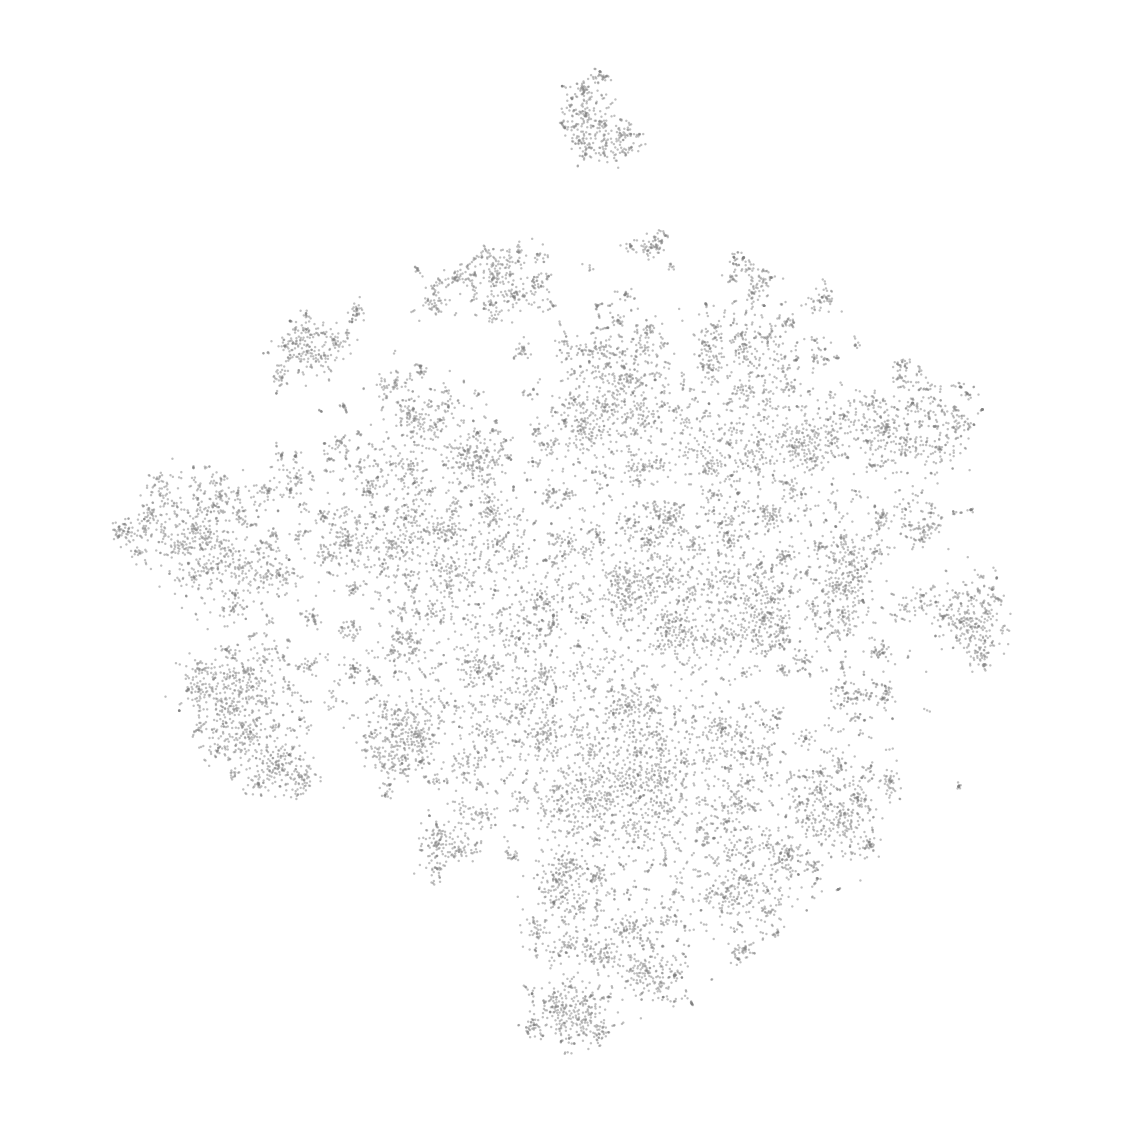

In [75]:
%matplotlib inline

tsne = tsne
fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=200, layout="constrained")

ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    s=3,  # Increase size
    c="grey",
    marker=".",
    linewidths=None,
    ec="None",
    alpha=0.5,  # Increase opacity
    rasterized=True,
)

ax.axis("equal")
ax.grid()
# ax.xticks([])
# ax.yticks([])
ax.axis("off")

fig.savefig(
    figures_path
    / "BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext_18609.png"
)